In [ ]:
!pip install transformers

In [1]:
import os
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,WeightedRandomSampler, random_split, SubsetRandomSampler, Subset
from sklearn.utils.class_weight import compute_class_weight
# Torch Vision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
# Utils
from tqdm import tqdm
import numpy as np
from typing import List
# Train Test Evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score
# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import torch.nn.functional as F

### Preparing The Models

In [2]:
g_vit_patch = 'google/vit-base-patch16-224'
base_path = './data' # For training Data
base_output_path = './output' # For Storing weights and all
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15
NUM_WORKERS = 4

In [13]:
# CNN Model with Explicit Device Handling
class CNNModel(nn.Module):
    def __init__(self, num_classes, device, cnn_model=models.resnet50(weights=models.ResNet50_Weights.DEFAULT)):
        super(CNNModel, self).__init__()
        self.cnn = cnn_model
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(num_ftrs, num_classes)
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)
        return self.cnn(x)

# ViT Model with Explicit Device Handling
class ViTModel(nn.Module):
    def __init__(self, num_classes, device, vit_model_name=g_vit_patch):
        super(ViTModel, self).__init__()
        self.feature_extractor = ViTImageProcessor.from_pretrained(vit_model_name,do_rescale=False)
        self.model = ViTForImageClassification.from_pretrained(
            vit_model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
        )
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)  # Move to the specified device
        # Prepare inputs for ViT model
        feature_input = self.feature_extractor(x, return_tensors="pt").to(self.device)
        logits = self.model(**feature_input).logits
        return logits


class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(input_dim, input_dim)
    
    def forward(self, x):
        attention_weights = F.softmax(self.attention(x), dim=1)
        return x * attention_weights

class EnsembleModel(nn.Module):
    def __init__(self, num_classes, cnn_model, vit_model, device):
        super().__init__()
        self.cnn_model = cnn_model
        self.vit_model = vit_model
        self.fc = nn.Linear(num_classes * 2, num_classes)  # Final linear layer
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)
        
        # Forward through CNN and ViT
        cnn_output = self.cnn_model(x)
        vit_output = self.vit_model(x)
        
        # Ensure outputs are the same shape
        if cnn_output.shape != vit_output.shape:
            raise ValueError(f"Shape mismatch: CNN output shape {cnn_output.shape}, ViT output shape {vit_output.shape}")
        
        # Combine outputs
        combined_output = torch.cat((cnn_output, vit_output), dim=1)
        
        # Apply dropout for regularization
        combined_output = F.dropout(combined_output, p=0.5)
        
        # Final linear output
        return self.fc(combined_output)

    def eval(self, *args, **kwargs):
        super().eval(*args, **kwargs)  # Call eval() on the parent class
        
        # Call eval() on the underlying models
        self.cnn_model.eval(*args, **kwargs)
        self.vit_model.eval(*args, **kwargs)
        
    def train(self, *args, **kwargs):
        super().train(*args, **kwargs)  # Call train() on the parent class
        
        # Call train() on the underlying models
        self.cnn_model.train(*args, **kwargs)
        self.vit_model.train(*args, **kwargs)



### Data Preparation

In [4]:

def preprocess(base_path: str, device: torch.device):
    # Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # Add more transformations if needed
        transforms.ToTensor(),
    ])

    print("Loading Datasets...")
    # Load datasets
    full_dataset = datasets.ImageFolder(
        root=base_path,
        transform=train_transform
    )

    # Calculate the train-test split
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size

    # Split the dataset into train and test sets
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # Create DataLoader for train and test sets
    train_loader = DataLoader(train_dataset, num_workers=4, batch_size=80, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, num_workers=4, batch_size=80, shuffle=False, pin_memory=True)

    print("All Done...")
    
    return train_loader, test_loader

In [5]:
# Define the folder where your ECG image data is stored
data_folder = os.path.join(base_path, 'image-data-cardiac-process')

train_loader, test_loader = preprocess(data_folder, device)

Loading Datasets...
All Done...


In [6]:
num_classes = len(train_loader.dataset.dataset.classes)


### Training Ensemble Model

In [7]:
class EpochEvaluator:
    def __init__(self, total_data_count: int, curr_epoch: int, total_epochs: int):
        self.running_loss = 0.0
        self.correct_preds = 0
        self.total_preds = 0
        self.total_data_count = total_data_count
        self.curr_epoch = curr_epoch
        self.total_epochs = total_epochs

    def update_loss(self, loss: float):
        self.running_loss += loss
        return self

    def update_preds(self, correct_preds: int, total_preds: int):
        self.correct_preds += correct_preds
        self.total_preds += total_preds
        return self

    def metrics(self):
        epoch_loss = self.running_loss / self.total_data_count
        epoch_accuracy = self.correct_preds / self.total_preds * 100
        return epoch_loss, epoch_accuracy

    def print_metrics(self):
        epoch_loss, epoch_accuracy = self.metrics()
        print(f'Epoch [{self.curr_epoch + 1}/{self.total_epochs}], '
              f'Training Loss: {epoch_loss:.4f}, '
              f'Training Accuracy: {epoch_accuracy:.2f}%')


class TrainEvaluator:
    def __init__(self):
        self.epochs = []

    def add(self, epoch: EpochEvaluator):
        self.epochs.append(epoch)

    def plot_graph(self):
        epoch_nums = [e.curr_epoch + 1 for e in self.epochs]
        losses = [e.metrics()[0] for e in self.epochs]
        accuracies = [e.metrics()[1] for e in self.epochs]

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epoch_nums, losses, 'o-', label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss vs Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epoch_nums, accuracies, 'o-', label='Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training Accuracy vs Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [8]:
# Define loss function and optimizer on the same device
def train_model(model, train_loader, num_epochs, learning_rate):
    train_eval = TrainEvaluator()
    
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    total_train = len(train_loader)
    print(f"{num_epochs=} {total_train=}")
    with tqdm(total=num_epochs * total_train) as pbar:
        for epoch in tqdm(range(num_epochs), position=0, leave=True):
            model.train()  # Set model to training mode
            epoch_eval = EpochEvaluator(total_train, epoch, num_epochs)
            # Iterate through training data
            for inputs, labels in tqdm(train_loader,total=total_train, position=0, leave=True):
                inputs,labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()  # Reset gradients
                outputs = model(inputs)  # Forward pass

                loss = criterion(outputs, labels)  # Calculate loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update model parameters
                pbar.update(1)

                _, predicted = outputs.max(1)
                epoch_eval.update_loss(
                    loss.item()
                ).update_preds(
                    (predicted == labels).sum().item(),labels.size(0)
                )
            epoch_eval.print_metrics()
            train_eval.add(epoch_eval)
    return train_eval
            
def test_model(model, test_loader):
    # Evaluate the model to get accuracy, F1 score, and ROC AUC
    model.eval()  # Set to evaluation mode
    # Initialize lists to store predictions and probabilities
    y_true = []
    y_pred = []
    y_proba = []

    total_test = len(test_loader)

    # Collect predictions and ground truth
    with torch.no_grad():        
        # Iterate through test data
        for inputs, labels in tqdm(test_loader, total=total_test):
            inputs,labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            probs = torch.softmax(outputs, dim=1)

            # Extend lists with values from current batch
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_proba.extend(probs.cpu().numpy())  # Get probabilities for ROC AUC

    # Reshape y_proba into a 2D array
    y_proba = np.array(y_proba)
    return y_true, y_pred, y_proba

In [9]:
# Save the trained models to disk
def save_models(base_path:str, *models):
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    # Save models to disk
    for model in models:
        torch.save(model.state_dict(), os.path.join(base_path, model.__class__.__name__))
    print("Models saved successfully!")
    


def load_model_with_weights_if_exists(model, base_path:str):
    model_name = model.__class__.__name__
    model_path = os.path.join(base_path, model_name)
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
    else:
        print('model not found: ', model_path, model_name)
    return model
    
# Load the trained models from disk
def load_models(device:torch.device, base_path:str):
    # Initialize models
    num_classes = 6
    cnn_model = load_model_with_weights_if_exists(CNNModel(num_classes,device))
    vit_model = load_model_with_weights_if_exists(ViTModel(num_classes,device))
    ensemble_model = load_model_with_weights_if_exists(EnsembleModel(num_classes, cnn_model, vit_model, device))
    
    # Move models to the GPU if available
    cnn_model = cnn_model.to(device)
    vit_model = vit_model.to(device)
    ensemble_model = ensemble_model.to(device)

    return cnn_model, vit_model, ensemble_model

In [14]:
# Initialize the models
cnn_model = CNNModel(num_classes,device)
vit_model = ViTModel(num_classes,device, g_vit_patch)
ensemble_model = EnsembleModel(num_classes, cnn_model, vit_model, device)

# Move models to the GPU if available
vit_model = vit_model.to(device)
vit_model = vit_model.to(device)
ensemble_model = ensemble_model.to(device)

model = ensemble_model

eval = train_model(model, train_loader, num_epochs, learning_rate=9e-6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num_epochs=15 total_train=637


100%|█████████▉| 636/637 [11:38<00:01,  1.08s/it]it]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  7%|▋         | 1/15 [11:38<2:42:57, 698.40s/it]

Epoch [1/15], Training Loss: 0.4613, Training Accuracy: 86.05%


 13%|█▎        | 2/15 [23:16<2:31:15, 698.11s/it]

Epoch [2/15], Training Loss: 0.3384, Training Accuracy: 89.20%


 20%|██        | 3/15 [34:53<2:19:34, 697.88s/it]

Epoch [3/15], Training Loss: 0.3051, Training Accuracy: 89.88%


 27%|██▋       | 4/15 [46:32<2:07:58, 698.03s/it]

Epoch [4/15], Training Loss: 0.2792, Training Accuracy: 90.80%


 33%|███▎      | 5/15 [58:10<1:56:21, 698.15s/it]

Epoch [5/15], Training Loss: 0.2520, Training Accuracy: 91.56%


 40%|████      | 6/15 [1:09:49<1:44:45, 698.35s/it]

Epoch [6/15], Training Loss: 0.2230, Training Accuracy: 92.55%


 47%|████▋     | 7/15 [1:21:27<1:33:07, 698.38s/it]

Epoch [7/15], Training Loss: 0.1942, Training Accuracy: 93.55%


 53%|█████▎    | 8/15 [1:33:06<1:21:29, 698.45s/it]

Epoch [8/15], Training Loss: 0.1667, Training Accuracy: 94.54%


 60%|██████    | 9/15 [1:44:44<1:09:50, 698.50s/it]

Epoch [9/15], Training Loss: 0.1485, Training Accuracy: 95.10%


 67%|██████▋   | 10/15 [1:56:23<58:13, 698.63s/it] 

Epoch [10/15], Training Loss: 0.1334, Training Accuracy: 95.52%


 73%|███████▎  | 11/15 [2:08:03<46:35, 698.85s/it]

Epoch [11/15], Training Loss: 0.1217, Training Accuracy: 95.84%


 80%|████████  | 12/15 [2:19:42<34:56, 698.99s/it]

Epoch [12/15], Training Loss: 0.1125, Training Accuracy: 96.32%


 87%|████████▋ | 13/15 [2:31:21<23:18, 699.09s/it]

Epoch [13/15], Training Loss: 0.1135, Training Accuracy: 96.31%


 93%|█████████▎| 14/15 [2:43:01<11:39, 699.16s/it]

Epoch [14/15], Training Loss: 0.1049, Training Accuracy: 96.60%


100%|██████████| 9555/9555 [2:54:40<00:00,  1.10s/it]

Epoch [15/15], Training Loss: 0.0955, Training Accuracy: 96.83%


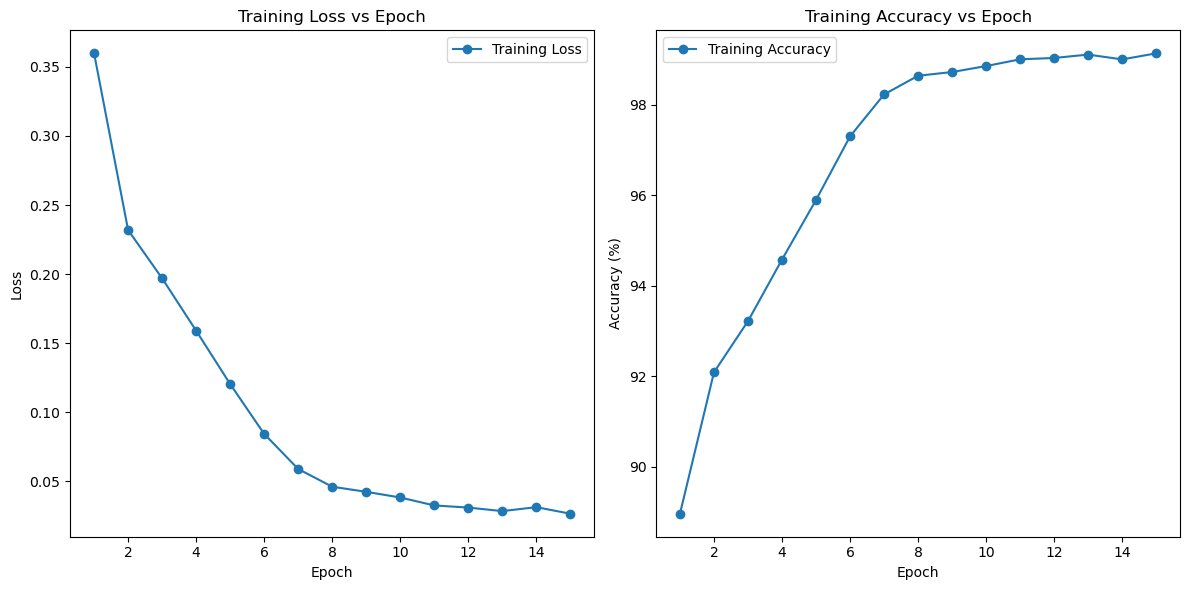

In [14]:
# Plot accuracy and loss for each fold
eval.plot_graph()

In [15]:
# export models
trained_model_path = os.path.join(base_output_path, "model_weights_vit_resnet_v1_clean_13ep")
save_models(trained_model_path, model)

Models saved successfully!


In [16]:
y_true, y_pred, y_proba = test_model(model, test_loader)

100%|██████████| 160/160 [01:28<00:00,  1.82it/s]


### Evaluation

In [46]:
y_true_binary = label_binarize(y_true, classes=np.arange(6))

In [47]:
y_true == y_pred

False

In [48]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate F1 score (weighted to account for class imbalance)
f1 = f1_score(y_true, y_pred, average='weighted')

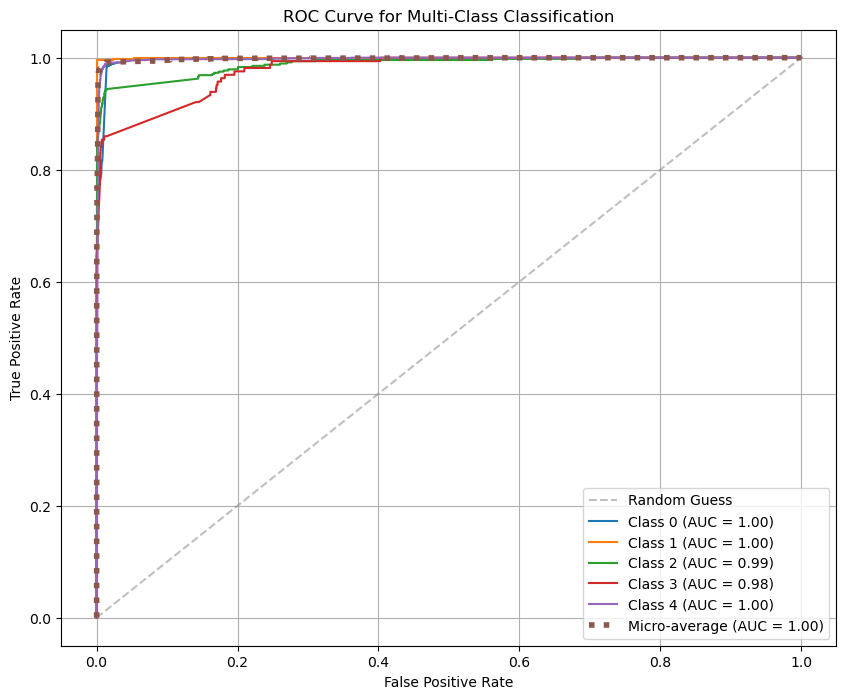

Average ROC AUC: 0.9983770559702373


In [49]:

# Calculate ROC curve and AUC for each class using scikit-learn
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), y_proba[:, i])
    roc_auc[i] = roc_auc_score((np.array(y_true) == i).astype(int), y_proba[:, i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(np.eye(num_classes)[np.array(y_true)].ravel(), y_proba.ravel())
roc_auc["micro"] = roc_auc_score(np.eye(num_classes)[np.array(y_true)], y_proba, average="micro")

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess', alpha=0.5)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print average ROC AUC
print("Average ROC AUC:", roc_auc["micro"])

Accuracy: 0.9808221331446986
F1 Score: 0.9804985935099183


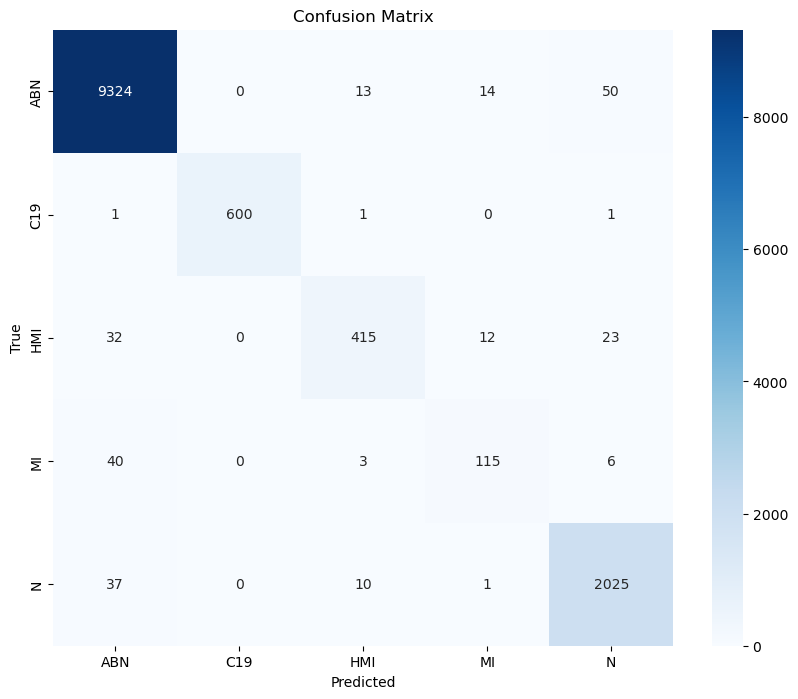

In [50]:
# Print accuracy and F1 score
print("Accuracy:", accuracy)
print("F1 Score:", f1)

# Confusion matrix for additional visualization
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.dataset.classes, yticklabels=test_loader.dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [51]:
recall_score(y_pred,y_true, average='weighted')

0.9808221331446986

In [29]:
vit_model = ViTModel(num_classes,device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# os.path.exists('./output/ViTModel')
weights = torch.load('./output/ViTModel')

In [44]:
vit_model.load_state_dict(weights)
vit_model.to(device)

ViTModel(
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (interm

In [45]:
y_true, y_pred, y_proba = test_model(vit_model, test_loader)

100%|██████████| 160/160 [01:13<00:00,  2.18it/s]


In [52]:
recall_score(y_pred,y_true, average='weighted')

0.9808221331446986

In [53]:
precision_score(y_pred,y_true, average='weighted')

0.981697478310762